In [14]:
# Data handling modules
import matplotlib as plt
import pandas as pd
import numpy as np
import geopandas as gpd #reference for Geopandas https://geopandas.org/mapping.html 

# Statistic modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Cluster modules
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, BisectingKMeans

# Plotting and mapping modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs

In [15]:
df=pd.read_csv('C:/Users/sarahann.USERS/Desktop/scripts_jp/agroecology_paper/data_processing/final_processing/ks_variables.csv',index_col=0)

In [16]:
df.describe()

,elevation,temp,precip,paws_050,om_kg_sq_m,sand,silt,clay,pet,depth_adj
count,254942.000000,254942.000000,254942.000000,254942.000000,254942.000000,254942.000000,254942.000000,254942.000000,254942.000000,254942.000000
mean,576.021915,12.635246,748.185268,8.727779,20.264492,21.055147,50.029593,28.902743,1282.998986,102.239998
std,248.309426,0.976629,201.466860,1.386446,6.004555,18.329924,13.299793,8.888432,113.653954,39.398239
min,214.000000,10.990321,428.999973,3.000000,1.000000,2.106361,1.000000,2.000000,312.524202,0.016439
25%,377.000000,12.000000,568.000003,7.971509,17.045989,9.115785,46.629674,22.711957,1193.703772,69.963200
50%,493.000000,13.000000,728.000044,8.994966,19.733991,14.932820,52.221932,27.953454,1272.000000,89.000000
75%,764.000000,13.000000,917.000073,10.000000,23.633012,23.597095,59.307286,36.431026,1375.000000,150.000000
max,1226.000000,15.000000,1205.499918,13.000000,69.845949,97.000000,75.666546,60.276055,1590.000000,150.000000


In [17]:
# Shape file of State of Kansas
fp= 'C:/Users/sarahann.USERS/Desktop/code/cb_2018_us_state_500k.shp' # state shape file. 
kansas = gpd.read_file(fp)
ks_map = kansas.NAME.isin(['Kansas']) 
ks_map = kansas[ks_map].loc[0:]
ks_map.to_crs(epsg=4269, inplace=True)

# County shape file, use for county lines
fp= 'C:/Users/sarahann.USERS/Desktop/code/us_county/US_County_Boundaries.shp' # county file

map_county = gpd.read_file(fp)
# Delete Non-contingous US counties 
ks_county = map_county.STATE.isin(['Kansas'])  
map_county = map_county[ks_county].loc[0:]
map_county.to_crs(epsg=4269, inplace=True)

map_df = gpd.read_file('C:/Users/sarahann.USERS/Desktop/scripts_jp/agroecology_paper/data_processing/final_processing/ks_variables.shape/ks_variables.shp')#('https://github.com/sarahannbowser/KS_agro_climatic_zones/blob/main/data/features/ks_variables.shape/ks_variables.shp?raw=true')  #

In [18]:
features=df.set_index('geometry') #geometry is maintained as the index for use in merging to map shape file
features=features.drop(columns=['elevation', 'silt', 'clay', 'sand'])
names=features.columns # obtain names of the features for future plotting

scaler= StandardScaler()
X= scaler.fit_transform(features)

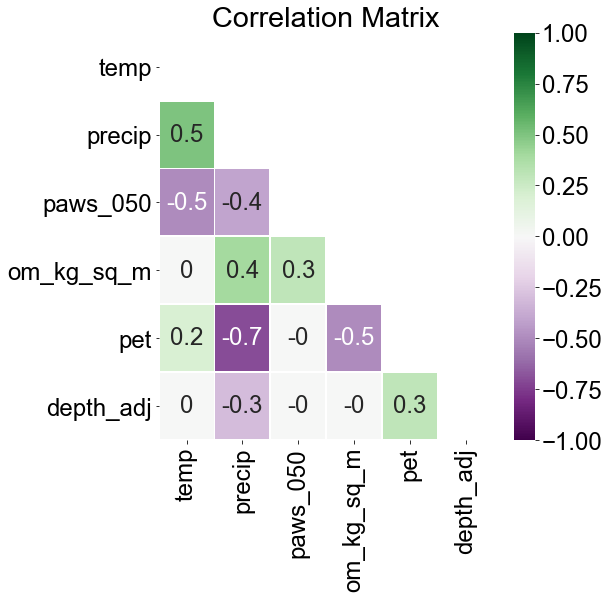

In [19]:
# Correlation Matrix
X_cor=pd.DataFrame(X, columns=names) # convert back to a pandas for use of corr() function
correlation = X_cor.corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(7.5,7.5)),
sns.heatmap(round(X_cor.corr(),1),
            vmin=-1, vmax=1,
            linewidths=1,
            cmap='PRGn',
            annot=True,
            mask=mask,
            label='test');

plt.title('Correlation Matrix')
plt.show()

In [20]:
# We have coorelation in the data, and our PCA chart shows that 95% of our desciptive ability is in 4 compontents

# We will use PCA to transform our data to a PCA with four compotents 
print('Orginal Data Shape with all Features')
print(X.shape)

# Transform Data
pca=PCA(.95).fit(X)
X=pca.transform(X) 
print('Data shape after PCA with all Features')
print(X.shape)

Orginal Data Shape with all Features
(254942, 6)
Data shape after PCA with all Features
(254942, 4)


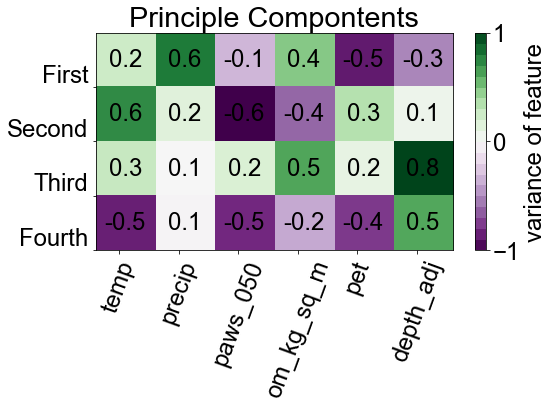

In [21]:
# Plot a matrix of the PCA compotents 
fig = plt.figure(figsize=(8, 4))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '24'
data=pca.components_
plt.imshow(pca.components_, interpolation = 'none', cmap = 'PRGn', aspect='auto')
#ax.imshow(data)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, "{:.1f}".format(data[i,j]), ha="center", va="center")
feature_names = names
plt.gca().set_xticks(np.arange(-.1, 5));
plt.gca().set_yticks(np.arange(0.5, 4));
plt.gca().set_xticklabels(feature_names, rotation=70, ha='center', fontsize=24);
plt.gca().set_yticklabels(['First', 'Second','Third', 'Fourth'], va='bottom', fontsize=24);
plt.gca().set_title('Principle Compontents')

norm = mpl.colors.Normalize(vmin=-1,vmax=1)
sm = plt.cm.ScalarMappable(cmap='PRGn', norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(-1,1,3), 
             boundaries=np.arange(-1,1.1,.1), label='variance of feature')

plt.show()

In [22]:
# Bisecting Kmeans loop to evaluate various cluster numbers
print ('Performance of Bisecting Kmeans models with different clusters')
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for n_clusters in range_n_clusters:
    clusters = BisectingKMeans(n_clusters=n_clusters)          
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, metric='sqeuclidean')
    silhouette_avg_e = silhouette_score(X, cluster_labels, metric='euclidean')# sqeuclidean
    silhouette_avg_s = silhouette_score(X, cluster_labels, metric='sqeuclidean')
    silhouette_avg_m = silhouette_score(X, cluster_labels, metric='manhattan')
    CHS_avg = calinski_harabasz_score(X, cluster_labels)
    print("For", n_clusters, "clusters",
              "euclidean silhouette score is:", round(silhouette_avg_e,2),
              "sqeuclidean silhouette score is:", round(silhouette_avg_s,2),
              "manhattan silhouette score is:", round(silhouette_avg_m,2),
              "and the calinski harabasz score is:", round(CHS_avg,2))

Performance of Bisecting Kmeans models with different clusters
For 2 clusters euclidean silhouette score is: 0.29 sqeuclidean silhouette score is: 0.44 manhattan silhouette score is: 0.29 and the calinski harabasz score is: 111261.25
For 3 clusters euclidean silhouette score is: 0.28 sqeuclidean silhouette score is: 0.41 manhattan silhouette score is: 0.3 and the calinski harabasz score is: 96126.39
For 4 clusters euclidean silhouette score is: 0.24 sqeuclidean silhouette score is: 0.38 manhattan silhouette score is: 0.24 and the calinski harabasz score is: 93581.91
For 5 clusters euclidean silhouette score is: 0.29 sqeuclidean silhouette score is: 0.43 manhattan silhouette score is: 0.28 and the calinski harabasz score is: 102599.84
For 6 clusters euclidean silhouette score is: 0.27 sqeuclidean silhouette score is: 0.4 manhattan silhouette score is: 0.26 and the calinski harabasz score is: 96112.89
For 7 clusters euclidean silhouette score is: 0.27 sqeuclidean silhouette score is: 0.4

In [8]:
# Run Clusters model for each of the models, with best performning parameters
clusters = BisectingKMeans(n_clusters=2)           
kmean_2_cluster = clusters.fit_predict(X)

clusters = BisectingKMeans(n_clusters=5)           
kmean_5_cluster = clusters.fit_predict(X)

clusters = BisectingKMeans(n_clusters=6)           
kmean_6_cluster = clusters.fit_predict(X)

clusters = BisectingKMeans(n_clusters=7)           
kmean_7_cluster = clusters.fit_predict(X)

clusters = BisectingKMeans(n_clusters=11)           
kmean_11_cluster = clusters.fit_predict(X)

In [9]:
#Add the macro cluster to the geo df
map_df['kmean2_cluster'] = kmean_2_cluster
map_df['kmean_5_cluster'] = kmean_5_cluster
map_df['kmean_6_cluster'] = kmean_6_cluster
map_df['kmean_7_cluster'] = kmean_7_cluster
map_df['kmean_11_cluster'] = kmean_11_cluster

map_df.head()

,elevation,temp,precip,paws_050,om_kg_sq_m,sand,silt,clay,pet,depth_adj,geometry,kmean2_cluster,kmean_5_cluster,kmean_6_cluster,kmean_7_cluster,kmean_11_cluster
0,1059.0,11.0,461.99998,10.200312,11.600936,36.791890,48.006241,15.402184,1293.999923,35.999998,"POLYGON ((-510199.207 1903111.481, -510950.491...",0,1,3,6,5
1,1028.0,11.0,460.99998,9.952817,13.037917,41.436857,44.328141,13.974322,1294.000000,150.000000,"POLYGON ((-509447.923 1902360.198, -510199.207...",0,2,4,3,8
2,1025.0,11.0,462.00000,9.419477,12.653916,36.736107,47.196245,16.109182,1293.999923,150.000000,"POLYGON ((-510199.207 1903111.481, -510199.207...",0,2,4,3,8
3,1009.0,11.0,461.00000,7.901502,13.091257,48.663049,35.083079,15.721448,1294.000000,150.000000,"POLYGON ((-508696.640 1903111.481, -508696.640...",0,2,4,3,8
4,1008.0,11.0,461.00000,7.430765,13.204286,49.223004,33.684108,16.610848,1294.000000,68.730928,"POLYGON ((-507945.356 1903111.481, -507945.356...",0,1,3,6,5


In [10]:
map_df.to_crs(epsg=4269, inplace=True)

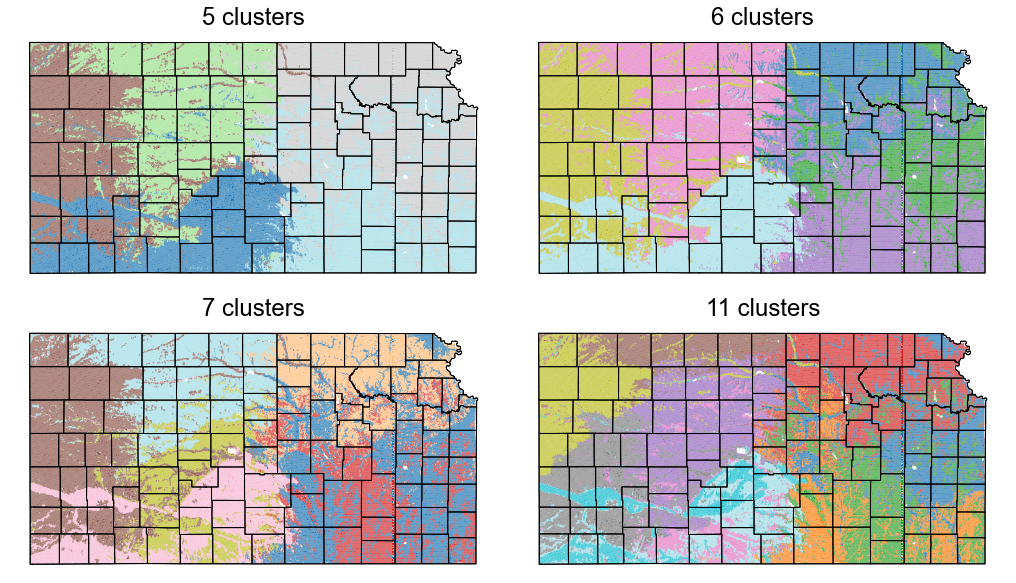

In [12]:
cmap = "tab20"

fig, axs = plt.subplots(2,2, figsize=(14,8), constrained_layout=True) 

plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 20

# First Plot
plot = map_df.plot(column=map_df.kmean_5_cluster, 
            cmap= cmap,  
            ax=axs[0,0], 
            ) 
axs[0,0].set_title('5 clusters')

# Second Plot
plot = map_df.plot(column=map_df.kmean_6_cluster,
            cmap= cmap,  
            ax=axs[0,1], 
            ) 
axs[0,1].set_title('6 clusters')

# Third Plot
plot = map_df.plot(column=map_df.kmean_7_cluster, 
            cmap= cmap,  
            ax=axs[1,0], 
            ) 
axs[1,0].set_title('7 clusters')

# Fourth Plot
plot = map_df.plot(column=map_df.kmean_11_cluster, 
            cmap= cmap,  
            ax=axs[1,1], 
            ) 
axs[1,1].set_title('11 clusters')

axs[0,0].set_axis_off()
axs[0,1].set_axis_off()
axs[1,0].set_axis_off()
axs[1,1].set_axis_off()

# Plot boundaries 
ks_map.plot(ax=axs[0,0], color='none', edgecolor='black')
map_county.plot(ax=axs[0,0], color='none', edgecolor='black', linewidths =1)
ks_map.plot(ax=axs[0,1], color='none', edgecolor='black')
map_county.plot(ax=axs[0,1], color='none', edgecolor='black', linewidths =1)
ks_map.plot(ax=axs[1,0], color='none', edgecolor='black')
map_county.plot(ax=axs[1,0], color='none', edgecolor='black', linewidths =1)
ks_map.plot(ax=axs[1,1], color='none', edgecolor='black')
map_county.plot(ax=axs[1,1], color='none', edgecolor='black', linewidths =1)

plt.show()

In [ ]:
map_df.to_csv('clusters.csv')
map_df.to_file('clusters.shape')

<ipython-input-13-ab022d34841d>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  map_df.to_file('clusters.shape')
